In [1]:
# set path
%cd /work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/Analysis/
#!/usr/bin/env python3
import uproot
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import pandas as pd
import awkward as ak
import seaborn as sns
import os
import vector
import time
# --- CONSTANTS ---
ELECTRON_MASS = 0.000511  # GeV/c^2
MUON_MASS = 0.1057        # GeV/c^2
HIGGS_MASS = 125.0        # GeV/c^2
Z_MASS = 91.1876          # GeV/c^2

def load_data(file_paths, tree_name, columns, max_events):
    """
    Loads data from multiple ROOT files into a dictionary of Akward arrays.
    """
    data = {}
    for name, path in file_paths.items():
        print(f"Loading data from {path}...")
        try:
            with uproot.open(path) as file:
                tree = file[tree_name]
                data[name] = tree.arrays(columns, entry_stop=max_events)
        except Exception as e:
            print(f"Error loading {path}: {e}")
            data[name] = None
    return data

# Configuration
TESTING_MODE = True
MAX_EVENTS = 10000 if TESTING_MODE else None
OUTPUT_DIR = "figure/test"
os.makedirs(OUTPUT_DIR, exist_ok=True)


file_paths = {
    "HLFV_150GeV" : "/work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/EventSample/MassScan_HZ4l_HLFV/HZ4l_HLFV_1M_HMass150_Seed150/HZ4l_HLFV_1M_HMass150_Seed150_IDEA.root",
    "HLFV_155GeV" : "/work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/EventSample/MassScan_HZ4l_HLFV/HZ4l_HLFV_1M_HMass155_Seed155/HZ4l_HLFV_1M_HMass155_Seed155_IDEA.root",
    "HLFV_160GeV" : "/work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/EventSample/MassScan_HZ4l_HLFV/HZ4l_HLFV_1M_HMass160_Seed160/HZ4l_HLFV_1M_HMass160_Seed160_IDEA.root",
    "zh_ll_tautau" : '/work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/Analysis/HighMassCut/zh_ll_tautau.root',
    "zh_ll_ww" : "/work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/Analysis/HighMassCut/zh_ll_ww.root",
    "zz_ll_tautau" : "/work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/Analysis/HighMassCut/zz_ll_tautau.root",
    "ZWW4l" : "/work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/EventSample/ZWWFourLepton_1M_Seed30/ZWWFourLepton_1M_Seed30.root"
    }

columns = [
    "MissingET_size", "MissingET.Eta", "MissingET.Phi", "MissingET.MET",
    "Jet_size", "Jet.Phi", "Jet.Eta", "Jet.PT", "Jet.Mass",
    "Electron_size", "Electron.Eta", "Electron.Phi", "Electron.PT","Electron.Charge",
    "Muon_size", "Muon.Eta", "Muon.Phi", "Muon.PT","Muon.Charge"
]

raw_data = load_data(file_paths, "Delphes", columns, MAX_EVENTS)


/work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/Analysis
Loading data from /work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/EventSample/MassScan_HZ4l_HLFV/HZ4l_HLFV_1M_HMass150_Seed150/HZ4l_HLFV_1M_HMass150_Seed150_IDEA.root...
Loading data from /work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/EventSample/MassScan_HZ4l_HLFV/HZ4l_HLFV_1M_HMass155_Seed155/HZ4l_HLFV_1M_HMass155_Seed155_IDEA.root...
Loading data from /work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/EventSample/MassScan_HZ4l_HLFV/HZ4l_HLFV_1M_HMass160_Seed160/HZ4l_HLFV_1M_HMass160_Seed160_IDEA.root...
Loading data from /work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/Analysis/HighMassCut/zh_ll_tautau.root...
Loading data from /work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/Analysis/HighMassCut/zh_ll_ww.root...
Loading data from /work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/Analysis/HighMassCut/zz_ll_tautau.root...
Loading data from /work/project/esci

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%cd /work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/Analysis/HighMassCut/images/

/work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/Analysis/HighMassCut/images


In [3]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
# from pypdf import PdfReader, PdfWriter  # pip install pypdf
import os

In [4]:
def plot_lepton_pt_distribution_after_cuts(raw_data, dataset_name):
    target_files = raw_data[dataset_name]
    cutstatus={}
    cutstatus["LestLeptonPT10GeV"] = ak.all(target_files["Electron.PT"] > 10, axis=1) & ak.all(target_files["Muon.PT"] > 10, axis=1)
        # secondt cut: exactly 4 leptons
    cutstatus["4LepEvent"] = (target_files["Electron_size"] + target_files["Muon_size"] == 4) & cutstatus["LestLeptonPT10GeV"]
    # third cut: odd number leptons
    cutstatus["OddNumberLep"] = (target_files["Electron_size"] % 2 != 0) & (target_files["Muon_size"] % 2 != 0) & cutstatus["4LepEvent"]
    # fourth cut: non charge-violation
    cutstatus["NonChargeViolation"] = (ak.prod(target_files["Electron.Charge"], axis=1) * ak.prod(target_files["Muon.Charge"],axis=1) == 1
                                    )&(ak.sum(target_files["Electron.Charge"],axis=1)+ak.sum(target_files["Muon.Charge"],axis=1) == 0
                                        )&(ak.all(target_files["Electron.Charge"],axis=1)&ak.all(target_files["Muon.Charge"],axis=1)
                                        )&(cutstatus["OddNumberLep"] == 1)
    Based_for_pairing=target_files[cutstatus["NonChargeViolation"]]
    PT_list=[]
    EventSize=len(Based_for_pairing)
    for EventNum in range(EventSize):
        ThisLepPT_List=[]
        Size_Elec=Based_for_pairing["Electron_size"][EventNum]
        Size_Muon=Based_for_pairing["Muon_size"][EventNum]
        for i in range(Size_Elec):
            ThisLepPT_List.append(Based_for_pairing["Electron.PT"][EventNum][i])
        for j in range(Size_Muon):
            ThisLepPT_List.append(Based_for_pairing["Muon.PT"][EventNum][j])
        ThisLepPT_List.sort(reverse=True)
        PT_list.append(ThisLepPT_List)
    np_PT_list=np.array(PT_list)
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.hist(np_PT_list.flatten(), bins=100, range=(0, 200), histtype='step', color='blue', alpha=0.7)
    ax.hist(np_PT_list[:,0], bins=100, range=(0, 200), histtype='step', color='red', alpha=0.7)
    ax.hist(np_PT_list[:,1], bins=100, range=(0, 200), histtype='step', color='green', alpha=0.7)
    ax.hist(np_PT_list[:,2], bins=100, range=(0, 200), histtype='step', color='orange', alpha=0.7)
    ax.hist(np_PT_list[:,3], bins=100, range=(0, 200), histtype='step', color='purple', alpha=0.7)
    ax.legend(['All Leptons', '1st Lepton', '2nd Lepton', '3rd Lepton', '4th Lepton'], fontsize=12)
    ax.set_title(f'Lepton PT Distribution after Cuts for {dataset_name}', fontsize=16)
    ax.set_xlabel('PT (GeV)', fontsize=14)
    ax.set_ylabel('Number of Leptons', fontsize=14)
    # plt.show()
    pdf.savefig()

In [5]:

# filename = 'Off-shell_PT_plot_noPT_allMore10.pdf'
# # 1. Initialize the PDF file
# with PdfPages(filename) as pdf:
#     dataset_names = ["HLFV_150GeV", "HLFV_155GeV", "HLFV_160GeV", "zh_ll_tautau", "zh_ll_ww", "zz_ll_tautau", "ZWW4l"]
#     for dataset_name in dataset_names:
#         plot_lepton_pt_distribution_after_cuts(raw_data, dataset_name)
            

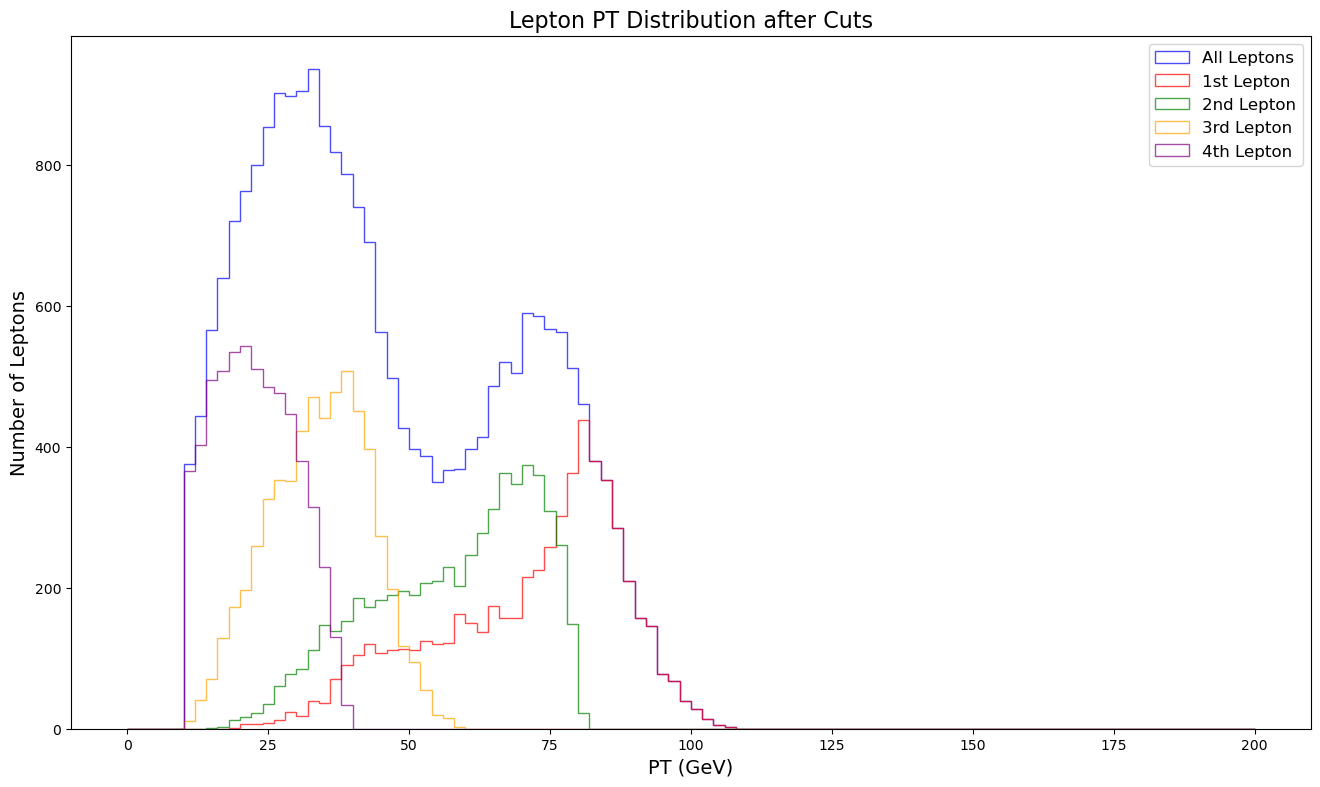

In [6]:
target_files = raw_data["HLFV_160GeV"]
cutstatus={}
cutstatus["LestLeptonPT10GeV"] = ak.all(target_files["Electron.PT"] > 10, axis=1) & ak.all(target_files["Muon.PT"] > 10, axis=1)
    # secondt cut: exactly 4 leptons
cutstatus["4LepEvent"] = (target_files["Electron_size"] + target_files["Muon_size"] == 4) & cutstatus["LestLeptonPT10GeV"]
# third cut: odd number leptons
cutstatus["OddNumberLep"] = (target_files["Electron_size"] % 2 != 0) & (target_files["Muon_size"] % 2 != 0) & cutstatus["4LepEvent"]
# fourth cut: non charge-violation
cutstatus["NonChargeViolation"] = (ak.prod(target_files["Electron.Charge"], axis=1) * ak.prod(target_files["Muon.Charge"],axis=1) == 1
                                )&(ak.sum(target_files["Electron.Charge"],axis=1)+ak.sum(target_files["Muon.Charge"],axis=1) == 0
                                    )&(ak.all(target_files["Electron.Charge"],axis=1)&ak.all(target_files["Muon.Charge"],axis=1)
                                    )&(cutstatus["OddNumberLep"] == 1)
Based_for_pairing=target_files[cutstatus["NonChargeViolation"]]
PT_list=[]
EventSize=len(Based_for_pairing)
for EventNum in range(EventSize):
    ThisLepPT_List=[]
    Size_Elec=Based_for_pairing["Electron_size"][EventNum]
    Size_Muon=Based_for_pairing["Muon_size"][EventNum]
    for i in range(Size_Elec):
        ThisLepPT_List.append(Based_for_pairing["Electron.PT"][EventNum][i])
    for j in range(Size_Muon):
        ThisLepPT_List.append(Based_for_pairing["Muon.PT"][EventNum][j])
    ThisLepPT_List.sort(reverse=True)
    PT_list.append(ThisLepPT_List)
np_PT_list=np.array(PT_list)
fig, ax = plt.subplots(figsize=(16, 9))
ax.hist(np_PT_list.flatten(), bins=100, range=(0, 200), histtype='step', color='blue', alpha=0.7)
ax.hist(np_PT_list[:,0], bins=100, range=(0, 200), histtype='step', color='red', alpha=0.7)
ax.hist(np_PT_list[:,1], bins=100, range=(0, 200), histtype='step', color='green', alpha=0.7)
ax.hist(np_PT_list[:,2], bins=100, range=(0, 200), histtype='step', color='orange', alpha=0.7)
ax.hist(np_PT_list[:,3], bins=100, range=(0, 200), histtype='step', color='purple', alpha=0.7)
ax.legend(['All Leptons', '1st Lepton', '2nd Lepton', '3rd Lepton', '4th Lepton'], fontsize=12)
ax.set_title('Lepton PT Distribution after Cuts', fontsize=16)
ax.set_xlabel('PT (GeV)', fontsize=14)
ax.set_ylabel('Number of Leptons', fontsize=14)
plt.show()
# pdf.savefig()

In [7]:
# analyze candiate pairing efficiency
condidate_size=[]
select_pair_mass=[]
unselected_pair_mass_list=[]
len_2_pack=[]
for i in range(EventSize):
    if Based_for_pairing["Electron_size"][i]==3:
        single_lepton="Muon"
        not_single_lepton="Electron"
    else:
        single_lepton="Electron"
        not_single_lepton="Muon"
    single_lepton_charge=Based_for_pairing[f"{single_lepton}.Charge"][i]
    candidate_charge=single_lepton_charge * -1
    single_lepton=vector.obj(
        pt=Based_for_pairing[f"{single_lepton}.PT"][i][0],
        eta=Based_for_pairing[f"{single_lepton}.Eta"][i][0],
        phi=Based_for_pairing[f"{single_lepton}.Phi"][i][0],
        mass=ELECTRON_MASS if single_lepton=="Electron" else MUON_MASS
    )
    candidate_pt=[]
    candidate_mass=[]
    notcandidate_mass=[]
    for j in range(Based_for_pairing[f"{not_single_lepton}_size"][i]):
        if (Based_for_pairing[f"{not_single_lepton}.Charge"][i][j]==candidate_charge) and (Based_for_pairing[f"{not_single_lepton}.PT"][i][j]>30):
            candidate_lepton=vector.obj(
                pt=Based_for_pairing[f"{not_single_lepton}.PT"][i][j],
                eta=Based_for_pairing[f"{not_single_lepton}.Eta"][i][j],
                phi=Based_for_pairing[f"{not_single_lepton}.Phi"][i][j],
                mass=ELECTRON_MASS if not_single_lepton=="Electron" else MUON_MASS
            )
            thispair_dr=single_lepton.deltaR(candidate_lepton)
            if thispair_dr<2.0:
                continue

            lepton_indexes=[0,1,2]
            lepton_indexes.remove(j)
            likely_Z_lap1=vector.obj(
                pt=Based_for_pairing[f"{not_single_lepton}.PT"][i][lepton_indexes[0]],
                eta=Based_for_pairing[f"{not_single_lepton}.Eta"][i][lepton_indexes[0]],
                phi=Based_for_pairing[f"{not_single_lepton}.Phi"][i][lepton_indexes[0]],
                mass=ELECTRON_MASS if not_single_lepton=="Electron" else MUON_MASS
            )
            likely_Z_lap2=vector.obj(
                pt=Based_for_pairing[f"{not_single_lepton}.PT"][i][lepton_indexes[1]],
                eta=Based_for_pairing[f"{not_single_lepton}.Eta"][i][lepton_indexes[1]],
                phi=Based_for_pairing[f"{not_single_lepton}.Phi"][i][lepton_indexes[1]],
                mass=ELECTRON_MASS if not_single_lepton=="Electron" else MUON_MASS
            )
            unselected_pair_mass=(likely_Z_lap1+likely_Z_lap2).mass
            # candidate_pt.append(Based_for_pairing[f"{not_single_lepton}.PT"][i][j])
            thispair_mass=(single_lepton+candidate_lepton).mass
            if (unselected_pair_mass>Z_MASS) or (unselected_pair_mass<50):
                continue
            candidate_pt.append(Based_for_pairing[f"{not_single_lepton}.PT"][i][j])
            candidate_mass.append(thispair_mass)
            notcandidate_mass.append(unselected_pair_mass)

    condidate_size.append(len(candidate_pt))
    if len(candidate_pt)==1:
        select_pair_mass.append(candidate_mass[0])
        notselected_mass=notcandidate_mass[0]
        unselected_pair_mass_list.append(notselected_mass)
    if len(candidate_pt)==2:
        # sort candidate_mass and notcandidate_mass in the same order, using candidate_mass reverse true as base
        # sorted_indices = np.argsort(candidate_mass)[::-1]
        sorted_pairs = sorted(zip(candidate_mass, notcandidate_mass), key=lambda x: x[0], reverse=True)
        len_2_pack.append(sorted_pairs)
        


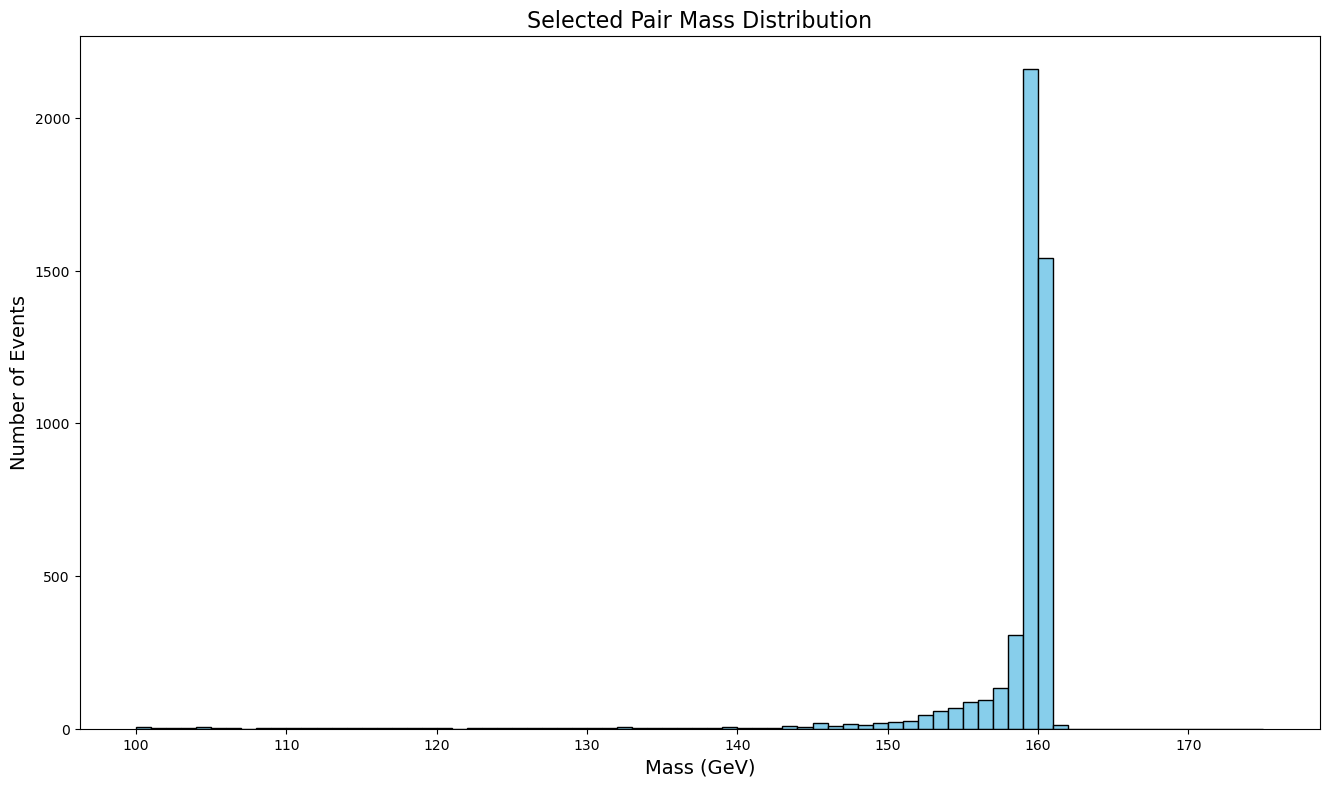

In [8]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.hist(select_pair_mass, bins=75, range=(100, 175), color='skyblue', edgecolor='black')
ax.set_title('Selected Pair Mass Distribution', fontsize=16)
ax.set_xlabel('Mass (GeV)', fontsize=14)
ax.set_ylabel('Number of Events', fontsize=14)
plt.show()

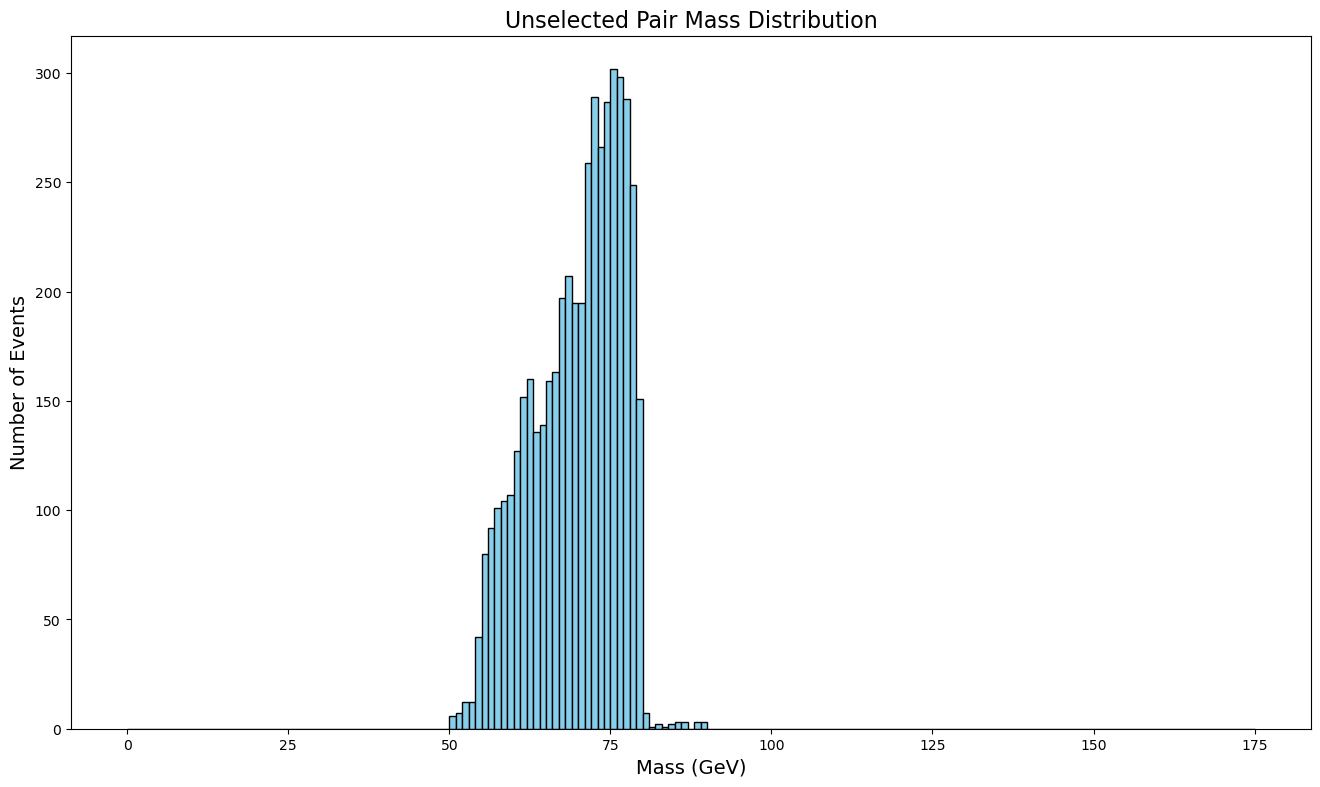

In [9]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.hist(unselected_pair_mass_list, bins=175, range=(0, 175), color='skyblue', edgecolor='black')
ax.set_title('Unselected Pair Mass Distribution', fontsize=16)
ax.set_xlabel('Mass (GeV)', fontsize=14)
ax.set_ylabel('Number of Events', fontsize=14)
plt.show()

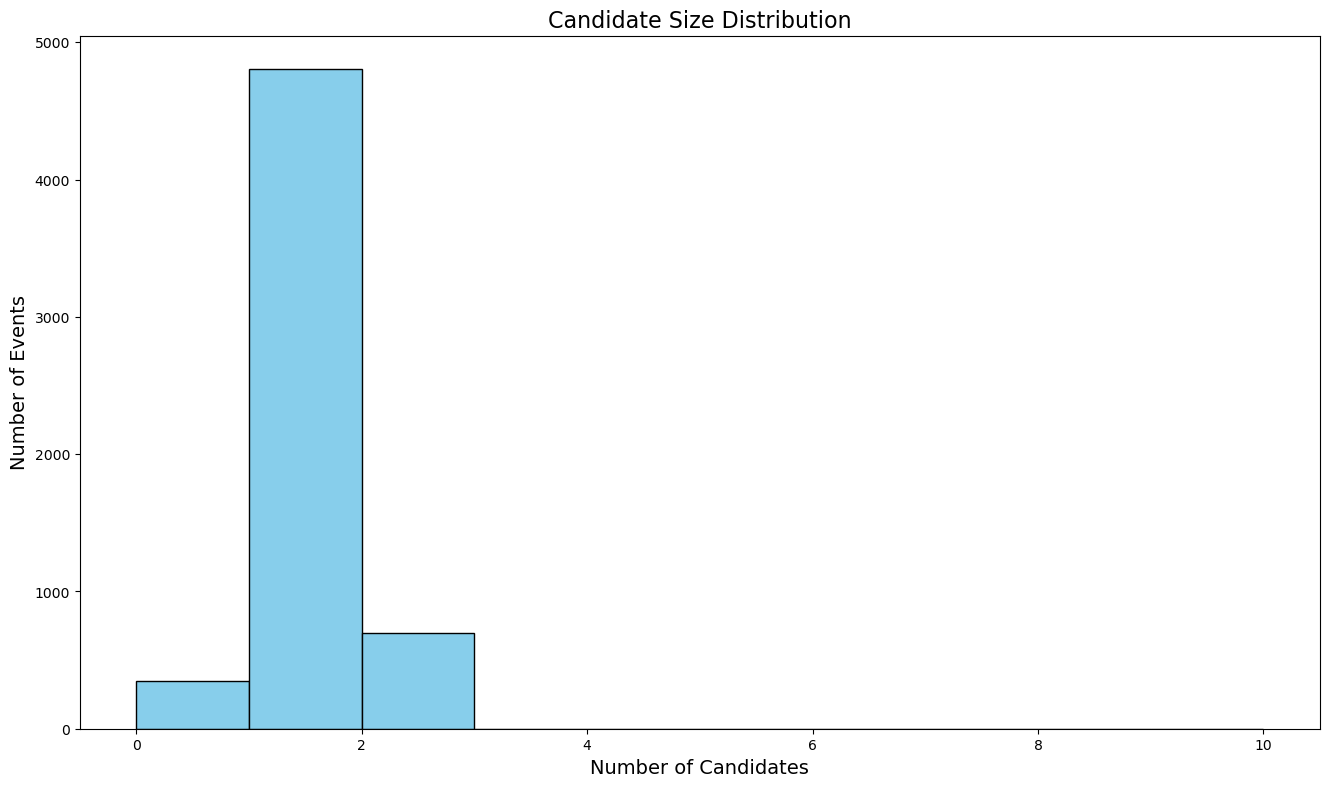

In [10]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.hist(condidate_size, bins=10, range=(0, 10), color='skyblue', edgecolor='black')
ax.set_title('Candidate Size Distribution', fontsize=16)
ax.set_xlabel('Number of Candidates', fontsize=14)
ax.set_ylabel('Number of Events', fontsize=14)
plt.show()

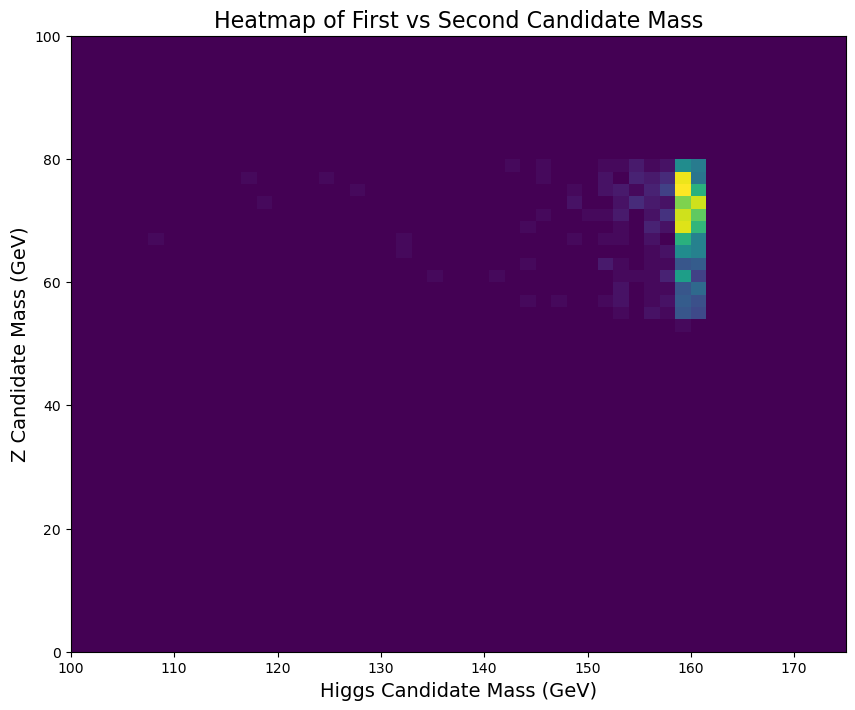

In [11]:
# np.array(len_2_pack)[:,0][:,0]
# plot heat map of first and second candidate mass in len_2_pack
fig, ax = plt.subplots(figsize=(10, 8))
package_np=np.array(len_2_pack)
first_masses = package_np[:,0][:,0]
second_masses = package_np[:,0][:,1]
heatmap, xedges, yedges = np.histogram2d(first_masses, second_masses, bins=50, range=[[100, 175], [0, 100]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
ax.imshow(heatmap.T, extent=extent, origin='lower', aspect='auto', cmap='viridis')
ax.set_title('Heatmap of First vs Second Candidate Mass', fontsize=16)
ax.set_xlabel('Higgs Candidate Mass (GeV)', fontsize=14)
ax.set_ylabel('Z Candidate Mass (GeV)', fontsize=14)
plt.show()

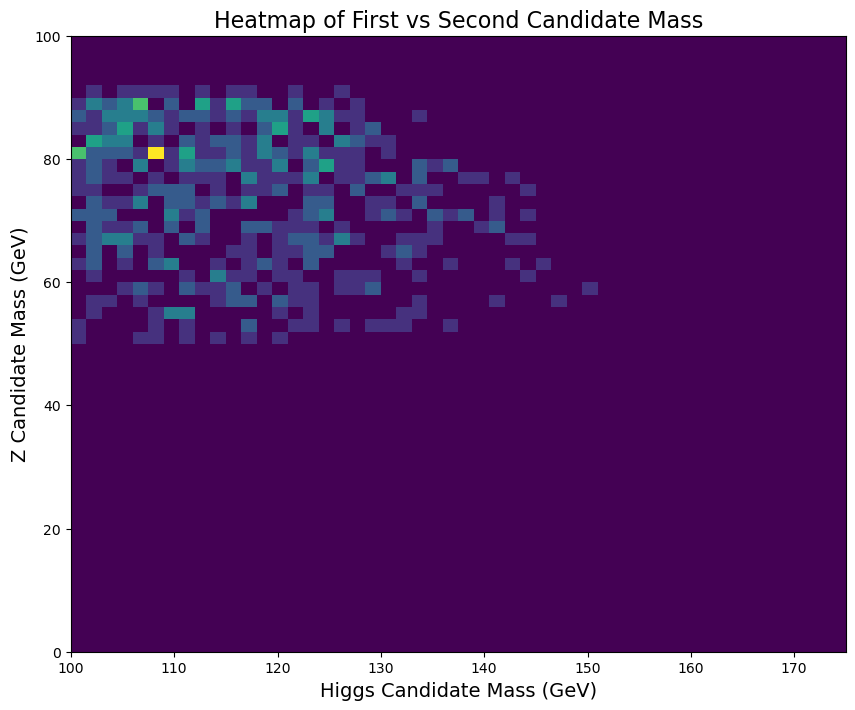

In [12]:
# pair with low mass
fig, ax = plt.subplots(figsize=(10, 8))
package_np=np.array(len_2_pack)
first_masses = package_np[:,1][:,0]
second_masses = package_np[:,1][:,1]
heatmap, xedges, yedges = np.histogram2d(first_masses, second_masses, bins=50, range=[[100, 175], [0, 100]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
ax.imshow(heatmap.T, extent=extent, origin='lower', aspect='auto', cmap='viridis')
ax.set_title('Heatmap of First vs Second Candidate Mass', fontsize=16)
ax.set_xlabel('Higgs Candidate Mass (GeV)', fontsize=14)
ax.set_ylabel('Z Candidate Mass (GeV)', fontsize=14)
plt.show()

In [30]:
z_sorted_by_z=[]
for list in len_2_pack:
    sorted_by_z=sorted(list, key=lambda x: x[1],reverse=True)
    z_sorted_by_z.append(sorted_by_z)
np_sort_z=np.array(z_sorted_by_z)

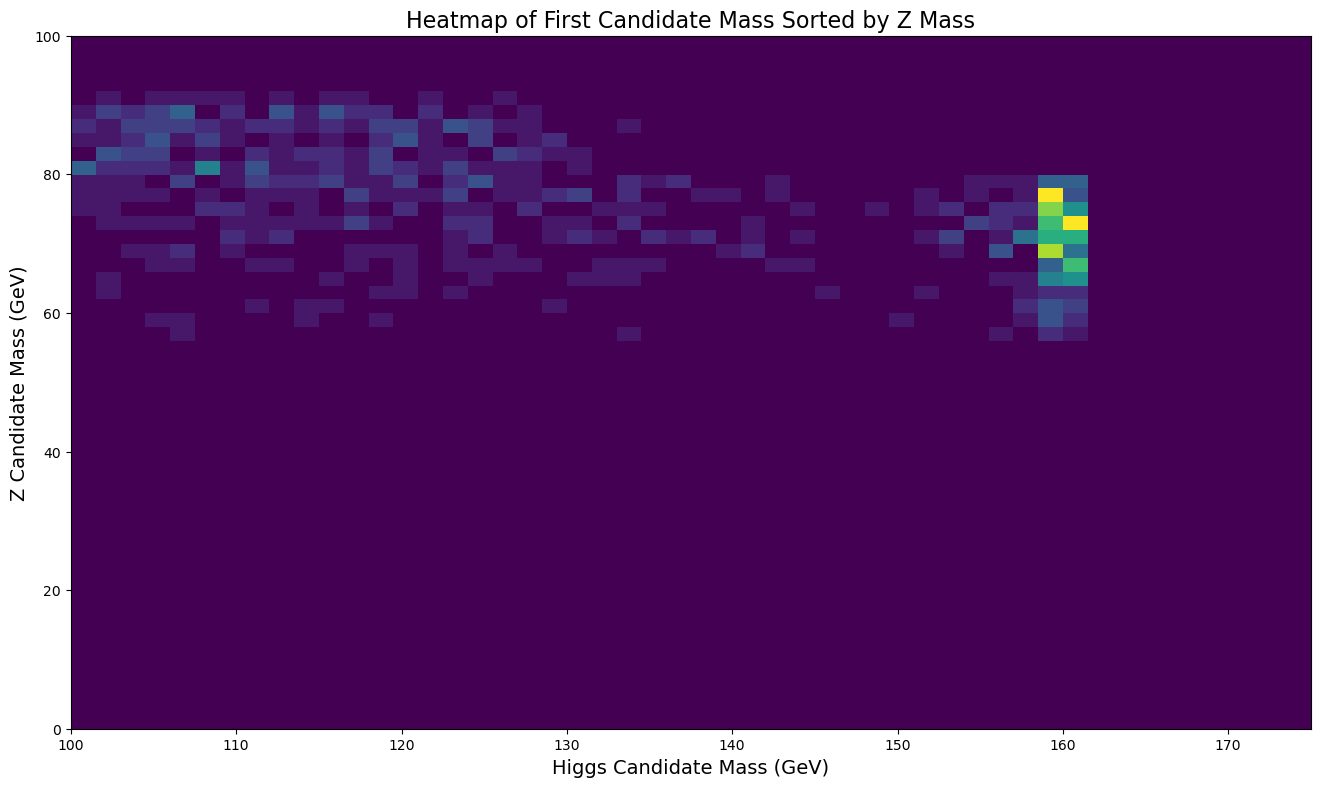

In [31]:
# heat map of z_sorted_by_z first candidate mass
fig, ax = plt.subplots(figsize=(16, 9))
heatmap, xedges, yedges = np.histogram2d(np_sort_z[:,0][:,0], np_sort_z[:,0][:,1], bins=50, range=[[100, 175], [0, 100]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
ax.imshow(heatmap.T, extent=extent, origin='lower', aspect='auto', cmap='viridis')
ax.set_title('Heatmap of First Candidate Mass Sorted by Z Mass', fontsize=16)
ax.set_xlabel('Higgs Candidate Mass (GeV)', fontsize=14)
ax.set_ylabel('Z Candidate Mass (GeV)', fontsize=14)
plt.show()

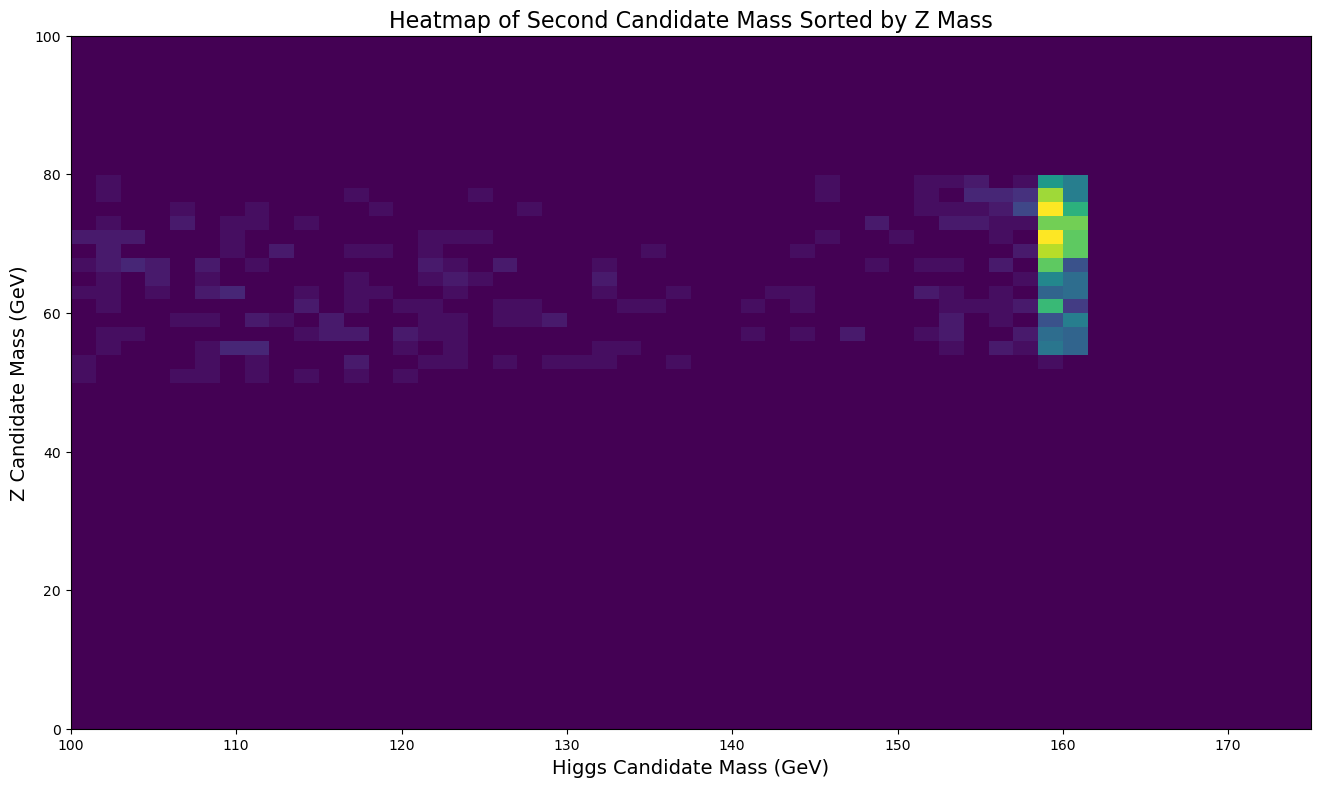

In [32]:
fig, ax = plt.subplots(figsize=(16, 9))
heatmap, xedges, yedges = np.histogram2d(np_sort_z[:,1][:,0], np_sort_z[:,1][:,1], bins=50, range=[[100, 175], [0, 100]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
ax.imshow(heatmap.T, extent=extent, origin='lower', aspect='auto', cmap='viridis')
ax.set_title('Heatmap of Second Candidate Mass Sorted by Z Mass', fontsize=16)
ax.set_xlabel('Higgs Candidate Mass (GeV)', fontsize=14)
ax.set_ylabel('Z Candidate Mass (GeV)', fontsize=14)
plt.show()

In [13]:
# Single lepton PT extraction
odd_plavor_pt=[]
odd_plavor_pt_electron=[]
odd_plavor_pt_muon=[]
for i in range(EventSize):
    if Based_for_pairing["Electron_size"][i] > Based_for_pairing["Muon_size"][i]:
        this_odd_pt=Based_for_pairing["Electron.PT"][i][0]
        odd_plavor_pt_electron.append(this_odd_pt)
    else:
        this_odd_pt=Based_for_pairing["Muon.PT"][i][0]
        odd_plavor_pt_muon.append(this_odd_pt)
    odd_plavor_pt.append(this_odd_pt)

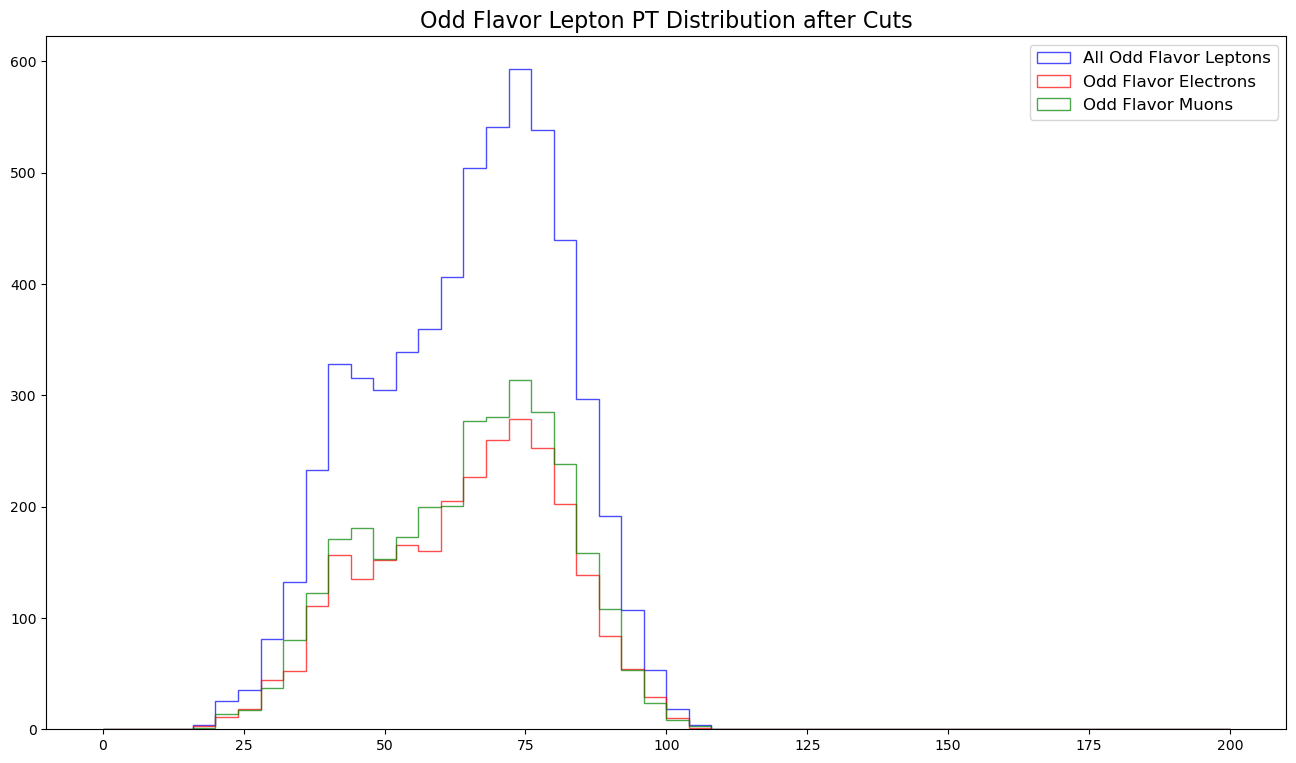

In [14]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.hist(odd_plavor_pt, bins=50, range=(0, 200), histtype='step', color='blue', alpha=0.7)
ax.hist(odd_plavor_pt_electron, bins=50, range=(0, 200), histtype='step', color='red', alpha=0.7)
ax.hist(odd_plavor_pt_muon, bins=50, range=(0, 200), histtype='step', color='green', alpha=0.7)
ax.legend(['All Odd Flavor Leptons', 'Odd Flavor Electrons', 'Odd Flavor Muons'], fontsize=12)
ax.set_title('Odd Flavor Lepton PT Distribution after Cuts', fontsize=16)
plt.show()


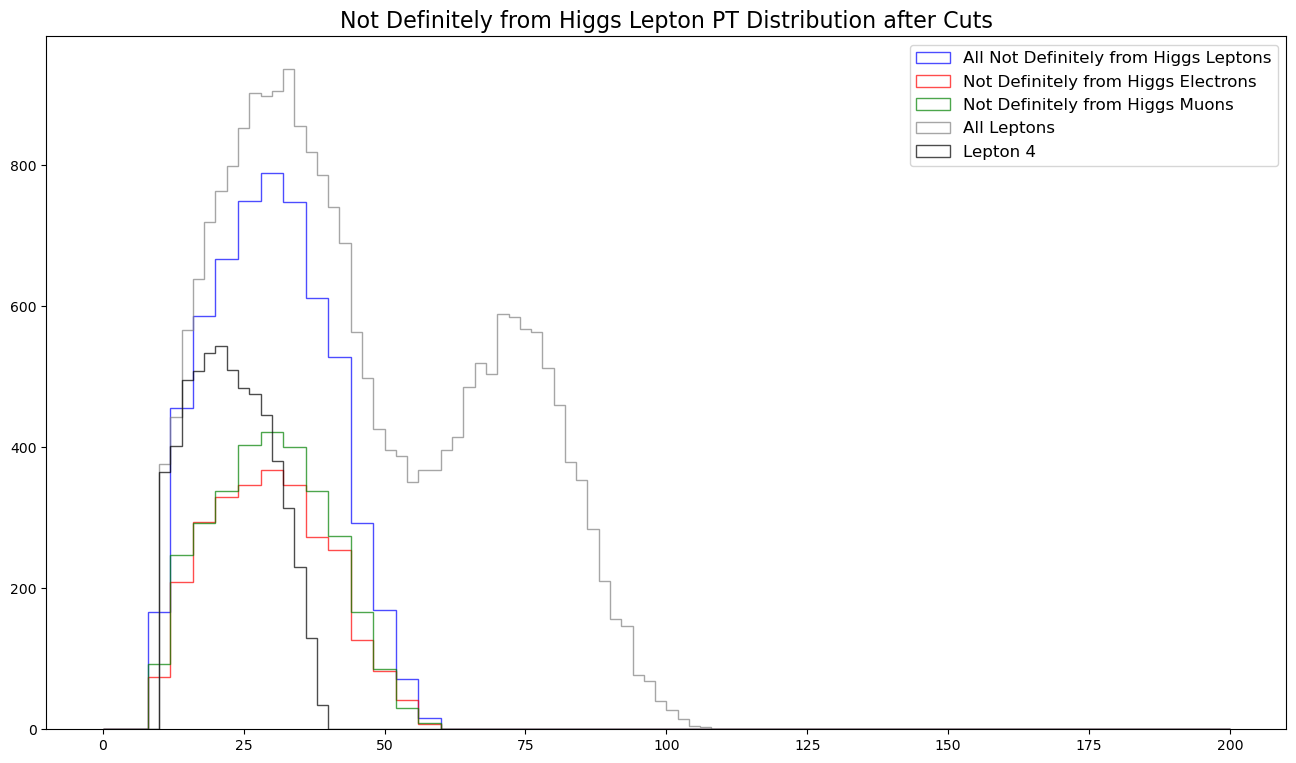

In [15]:
# plot the pt distribution of not definitely from higgs boson
not_higgs_pt=[]
not_higgs_pt_electron=[]
not_higgs_pt_muon=[]
for i in range(EventSize):
    if Based_for_pairing["Electron_size"][i] > Based_for_pairing["Muon_size"][i]:
        this_def_nit_higgs_charge=Based_for_pairing["Muon.Charge"][i][0]
        for j in range(Based_for_pairing["Electron_size"][i]):
            if Based_for_pairing["Electron.Charge"][i][j] == this_def_nit_higgs_charge:
                this_not_higgs_pt=Based_for_pairing["Electron.PT"][i][j]
                not_higgs_pt_electron.append(this_not_higgs_pt)
    else:
        this_def_nit_higgs_charge=Based_for_pairing["Electron.Charge"][i][0]
        for j in range(Based_for_pairing["Muon_size"][i]):
            if Based_for_pairing["Muon.Charge"][i][j] == this_def_nit_higgs_charge:
                this_not_higgs_pt=Based_for_pairing["Muon.PT"][i][j]
                not_higgs_pt_muon.append(this_not_higgs_pt)
    not_higgs_pt.append(this_not_higgs_pt)

fig, ax = plt.subplots(figsize=(16, 9))
ax.hist(not_higgs_pt, bins=50, range=(0, 200), histtype='step', color='blue', alpha=0.7)
ax.hist(not_higgs_pt_electron, bins=50, range=(0, 200), histtype='step', color='red', alpha=0.7)
ax.hist(not_higgs_pt_muon, bins=50, range=(0, 200), histtype='step', color='green', alpha=0.7)
ax.hist(np_PT_list.flatten(), bins=100, range=(0, 200), histtype='step', color='gray', alpha=0.7)
ax.hist(np_PT_list[:,3], bins=100, range=(0, 200), histtype='step', color='black', alpha=0.7)
ax.legend(['All Not Definitely from Higgs Leptons', 'Not Definitely from Higgs Electrons', 'Not Definitely from Higgs Muons', 'All Leptons', 'Lepton 4'], fontsize=12)
ax.set_title('Not Definitely from Higgs Lepton PT Distribution after Cuts', fontsize=16)
plt.show()

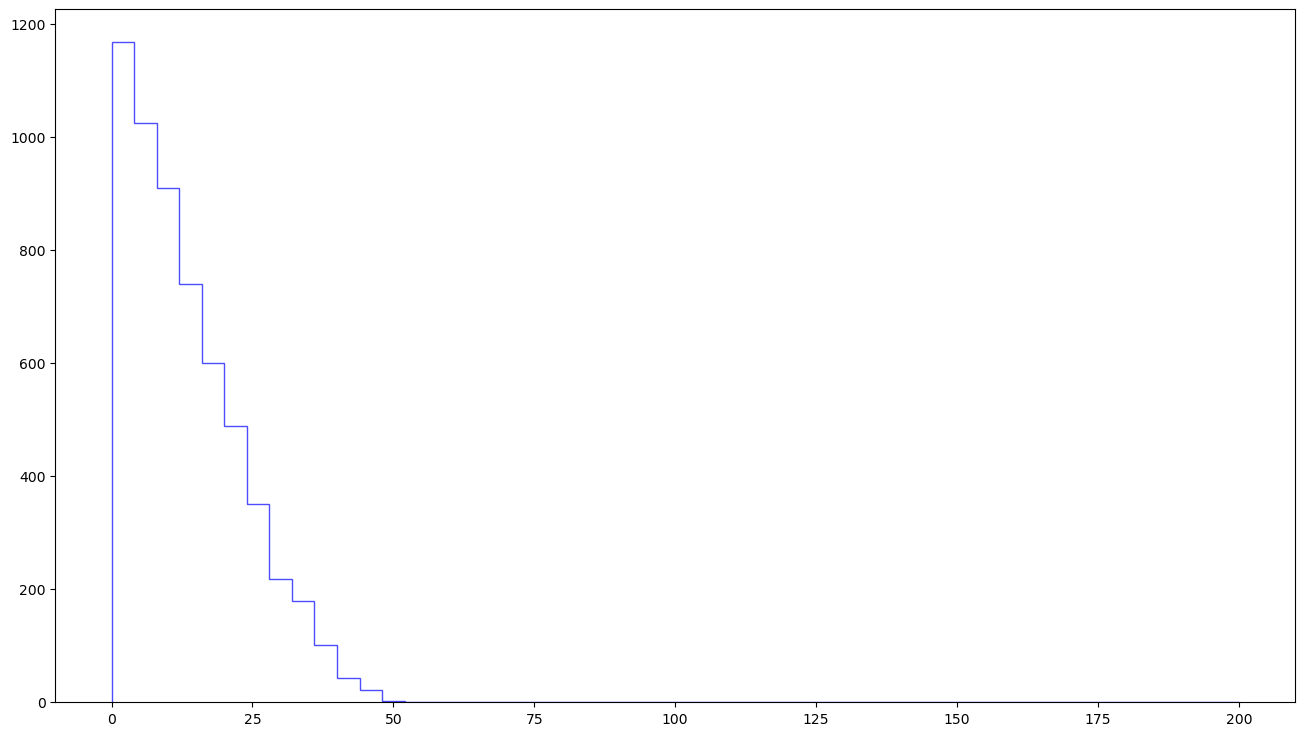

In [16]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.hist(np_PT_list[:,0]-np_PT_list[:,1], bins=50, range=(0, 200), histtype='step', color='blue', alpha=0.7)
plt.show()

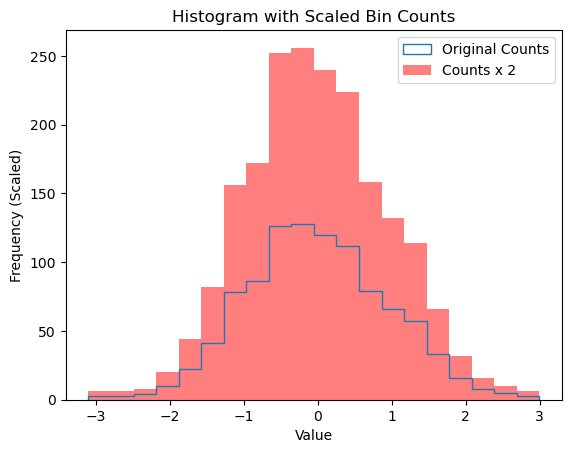

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Generate some sample data
data = np.random.randn(1000)

# 2. Compute the original histogram counts and bins
# We use the underscore "_" to ignore the "patches" output
counts, bins, _ = plt.hist(data, bins=20, histtype='step', label='Original Counts')

# 3. Multiply the counts by 2
scaled_counts = counts * 2

# 4. Plot the new, scaled histogram using plt.stairs or plt.bar
# For plt.stairs, we use the full bins array
plt.stairs(scaled_counts, bins, color='red', alpha=0.5, label='Counts x 2', fill=True)

# Alternative using plt.bar(): requires calculating bin centers or using bins[:-1] for x-positions
# bin_widths = np.diff(bins)
# plt.bar(bins[:-1], scaled_counts, width=bin_widths, color='orange', alpha=0.5, align='edge', label='Counts x 2 (bar)')


# Add labels and legend for clarity
plt.xlabel("Value")
plt.ylabel("Frequency (Scaled)")
plt.title("Histogram with Scaled Bin Counts")
plt.legend()
plt.show()


In [18]:
print("\nChecking uncut events...")
for name, arr in raw_data.items():
    all_events=MAX_EVENTS if MAX_EVENTS is not None else len(arr)
    # Use a list of dictionaries for easier field addition later
    additional_fields = {}
    print(f"      {name}: {len(arr)} events")
    print(f"-> Applying cut on {name}...")
    # First cut: Every lepton > 10 GeV
    additional_fields["LestLeptonPT10GeV"] = ak.all(arr["Electron.PT"] > 10, axis=1) & ak.all(arr["Muon.PT"] > 10, axis=1)
    # secondt cut: exactly 4 leptons
    additional_fields["4LepEvent"] = (arr["Electron_size"] + arr["Muon_size"] == 4) & additional_fields["LestLeptonPT10GeV"]
    # third cut: odd number leptons
    additional_fields["OddNumberLep"] = (arr["Electron_size"] % 2 != 0) & (arr["Muon_size"] % 2 != 0) & additional_fields["4LepEvent"]
    # fourth cut: non charge-violation
    additional_fields["NonChargeViolation"] = (ak.prod(arr["Electron.Charge"], axis=1) * ak.prod(arr["Muon.Charge"],axis=1) == 1
                                   )&(ak.sum(arr["Electron.Charge"],axis=1)+ak.sum(arr["Muon.Charge"],axis=1) == 0
                                      )&(ak.all(arr["Electron.Charge"],axis=1)&ak.all(arr["Muon.Charge"],axis=1)
                                      )&(additional_fields["OddNumberLep"] == 1)
    # Pre-Fourth cut:
    
        # test 
    # testarray=arr[additional_fields["3rdCut"]][:100]
    testarray=ak.mask(arr,additional_fields["NonChargeViolation"])
    lmass={"Electron":ELECTRON_MASS,"Muon":MUON_MASS}
    bothZmasses={}
    bothReHiggsMass={}
    bothHiggsMass={}
    bothEditReDeMETHiggs={}
    leptons={"Electron","Muon"}


    # Useing Z mas as criterion to select lepton type
    for lepton in leptons:
        muonpaircombinations=ak.combinations(testarray[lepton+".Charge"],2,axis=1)
        muonpaircombinations_mask=muonpaircombinations['1']!=muonpaircombinations['0']
        muonpaircombinationsarg=ak.argcombinations(testarray[lepton+".Charge"],2,axis=1)
        Newmuonpairarg=ak.mask(muonpaircombinationsarg,muonpaircombinations_mask)
        FirstMuon=vector.zip({
            "pt": testarray[lepton+".PT"][Newmuonpairarg["0"]],
            "eta": testarray[lepton+".Eta"][Newmuonpairarg["0"]], 
            "phi": testarray[lepton+".Phi"][Newmuonpairarg["0"]],
            "mass": [lmass[lepton]]*muonpaircombinations_mask
        })
        SecondMuon=vector.zip({
            "pt": testarray[lepton+".PT"][Newmuonpairarg["1"]],
            "eta": testarray[lepton+".Eta"][Newmuonpairarg["1"]], 
            "phi": testarray[lepton+".Phi"][Newmuonpairarg["1"]],
            "mass": [lmass[lepton]]*muonpaircombinations_mask
        })
        MuonPair=FirstMuon+SecondMuon
        Zcandi=abs(MuonPair.mass-Z_MASS)
        BestZIndex=ak.argmin(Zcandi,axis=1,keepdims=True)
        BestZMass=ak.firsts(MuonPair.mass[BestZIndex])
        bothZmasses[lepton]=BestZMass
        RecoiledHiggsMass=(vector.obj(px=0,py=0,pz=0,energy=240)-MuonPair[BestZIndex]).mass
        bothReHiggsMass[lepton]=RecoiledHiggsMass

        # 'selectLFV_mask' 3 leptons left indexes after selecting best Z pair
        selectLFV_mask=3-muonpaircombinationsarg[BestZIndex]['0']-muonpaircombinationsarg[BestZIndex]['1']
        FirstLFV=vector.zip({
            "pt": ak.firsts(testarray[lepton+".PT"][selectLFV_mask]),
            "eta": ak.firsts(testarray[lepton+".Eta"][selectLFV_mask]),
            "phi": ak.firsts(testarray[lepton+".Phi"][selectLFV_mask]),
            "mass": [lmass[lepton]]*ak.num(selectLFV_mask)
        }) # --- IGNORE ---
        anotherlepton=({"Electron","Muon"}-{lepton}).pop()
        secondLFV=vector.zip({
            "pt": ak.firsts(testarray[anotherlepton+".PT"]),
            "eta": ak.firsts(testarray[anotherlepton+".Eta"]),
            "phi": ak.firsts(testarray[anotherlepton+".Phi"]),
            "mass": [lmass[anotherlepton]]*ak.num(selectLFV_mask)
        }) # --- IGNORE ---
        HiggsM=(FirstLFV+secondLFV).mass
        bothHiggsMass[lepton]=HiggsM

    # Using Higgs mass as criterion to select lepton type
    HiggsPairCandidates=ak.cartesian([testarray["Electron.Charge"],testarray["Muon.Charge"]],axis=1)
    HiggsPairCandidates_mask=(HiggsPairCandidates['0']!=HiggsPairCandidates['1'])
    HiggsPairCandidatesarg=ak.argcartesian([testarray["Electron.Charge"],testarray["Muon.Charge"]],axis=1)
    HiggsPairCandidatesarg=ak.mask(HiggsPairCandidatesarg,HiggsPairCandidates_mask)
    FirstHiggsInPair=vector.zip({
        "pt": testarray["Electron.PT"][HiggsPairCandidatesarg["0"]],
        "eta": testarray["Electron.Eta"][HiggsPairCandidatesarg["0"]], 
        "phi": testarray["Electron.Phi"][HiggsPairCandidatesarg["0"]],
        "mass": [ELECTRON_MASS]*ak.num(HiggsPairCandidates_mask)
    })
    SecondHiggsInPair=vector.zip({
        "pt": testarray["Muon.PT"][HiggsPairCandidatesarg["1"]],
        "eta": testarray["Muon.Eta"][HiggsPairCandidatesarg["1"]], 
        "phi": testarray["Muon.Phi"][HiggsPairCandidatesarg["1"]],
        "mass": [MUON_MASS]*ak.num(HiggsPairCandidates_mask)
    })
    HiggsPair=FirstHiggsInPair+SecondHiggsInPair
    HiggsPairMass=HiggsPair.mass
    HiggsPairDeltaMass=abs(HiggsPairMass-HIGGS_MASS)
    BestHiggsPairIndex=ak.argmin(HiggsPairDeltaMass,axis=1,keepdims=True)
    BestHiggsPairMass=ak.firsts(HiggsPairMass[BestHiggsPairIndex])
    ZRecoiledMass=(vector.obj(px=0,py=0,pz=0,energy=240)-HiggsPair[BestHiggsPairIndex]).mass


    # Selecting lepton type for Z reconstruction based on Higgs mass
    PTlTypeCandidate=ak.where(arr["Electron_size"]==1,arr["Muon.PT"],arr["Electron.PT"])
    EataLTypeCandidate=ak.where(arr["Electron_size"]==1,arr["Muon.Eta"],arr["Electron.Eta"])
    PhiLTypeCandidate=ak.where(arr["Electron_size"]==1,arr["Muon.Phi"],arr["Electron.Phi"])
    LTypeCandidateMass=ak.where(arr["Electron_size"]==1,MUON_MASS,ELECTRON_MASS)
    LTypeCandidate=vector.zip({
        "pt": PTlTypeCandidate,
        "eta": EataLTypeCandidate, 
        "phi": PhiLTypeCandidate,
        "mass": LTypeCandidateMass
    })
    num=len(BestHiggsPairIndex)
    NotNone_mask=~ak.is_none(BestHiggsPairIndex)
    row=np.arange(num)
    Zpair_mask=np.full((num,3),True)
    Zpair_mask[row[NotNone_mask],ak.firsts(BestHiggsPairIndex[NotNone_mask])]=False
    Zpair_mask=ak.mask(Zpair_mask,NotNone_mask)
    RecoZpair=ak.combinations(LTypeCandidate[Zpair_mask],2,axis=1)
    Zpair=RecoZpair['0']+RecoZpair['1']
    ZpairMass=Zpair.mass
    # Identifying lepton type based on Z mass
    ZfirstLFlavor=ak.where(arr['Electron_size']==3,["EE"],["MuMu"])


    additional_fields["Z_selectionMass"]=ak.where(~ak.is_none(bothZmasses["Electron"]),bothZmasses["Electron"],bothZmasses["Muon"])
    # additional_fields["Higgs_recoiledMass"]=ak.firsts(ak.where(~ak.is_none(bothZmasses["Electron"]),bothReHiggsMass["Electron"],bothReHiggsMass["Muon"]))
    additional_fields["Higgs_reconstructedMass"]=ak.where(~ak.is_none(bothHiggsMass["Electron"]),bothHiggsMass["Electron"],bothHiggsMass["Muon"])
    # additional_fields["Higgs_selectionMass"]=BestHiggsPairMass
    # additional_fields["Z_recoiledMass"]=ak.firsts(ZRecoiledMass)
    # additional_fields["Z_reconstructedMass"]=ak.firsts(ZpairMass)
    additional_fields["Z_Windows"]=abs((additional_fields["Z_selectionMass"] - Z_MASS))<10
    # Add all new fields to the array at once
    for field_name, field_values in additional_fields.items():
        raw_data[name] = ak.with_field(raw_data[name], field_values, field_name)
print("----------------------------***-------------------------------")



Checking uncut events...
      HLFV_150GeV: 10000 events
-> Applying cut on HLFV_150GeV...
      HLFV_155GeV: 10000 events
-> Applying cut on HLFV_155GeV...
      HLFV_160GeV: 10000 events
-> Applying cut on HLFV_160GeV...
      zh_ll_tautau: 10000 events
-> Applying cut on zh_ll_tautau...
      zh_ll_ww: 10000 events
-> Applying cut on zh_ll_ww...
      zz_ll_tautau: 10000 events
-> Applying cut on zz_ll_tautau...
      ZWW4l: 10000 events
-> Applying cut on ZWW4l...
----------------------------***-------------------------------


In [19]:
ak.sum(raw_data['ZWW4Lep']['Z_Windows'])

KeyError: 'ZWW4Lep'

In [ ]:
ak.sum(abs(raw_data['ZWW4Lep']['Higgs_reconstructedMass'][raw_data['ZWW4Lep']['Z_Windows']] - 120.0) < 10.0)

3

In [ ]:
# print selection summary
tttlist=['LestLeptonPT10GeV','4LepEvent','OddNumberLep','NonChargeViolation']
for nn in tttlist:
    print("----------------------------***-------------------------------")
    print(f"Applying cut: {nn}")
    print(f"Selection summary for {name}:")
    print(f": {sum(raw_data['LFV_hm125'][nn])}")

----------------------------***-------------------------------
Applying cut: LestLeptonPT10GeV
Selection summary for LFV_hm125:
: 952655
----------------------------***-------------------------------
Applying cut: 4LepEvent
Selection summary for LFV_hm125:
: 616326
----------------------------***-------------------------------
Applying cut: OddNumberLep
Selection summary for LFV_hm125:
: 616306
----------------------------***-------------------------------
Applying cut: NonChargeViolation
Selection summary for LFV_hm125:
: 616295


In [ ]:
This_data.fields

['MissingET_size',
 'MissingET.Eta',
 'MissingET.Phi',
 'MissingET.MET',
 'Jet_size',
 'Jet.Phi',
 'Jet.Eta',
 'Jet.PT',
 'Jet.Mass',
 'Electron_size',
 'Electron.Eta',
 'Electron.Phi',
 'Electron.PT',
 'Electron.Charge',
 'Muon_size',
 'Muon.Eta',
 'Muon.Phi',
 'Muon.PT',
 'Muon.Charge',
 'LestLeptonPT10GeV',
 '4LepEvent',
 'OddNumberLep',
 'NonChargeViolation',
 'Z_selectionMass',
 'Higgs_recoiledMass',
 'Higgs_reconstructedMass',
 'Higgs_selectionMass',
 'Z_recoiledMass',
 'Z_reconstructedMass']

In [ ]:
# Additional Selection
for data_key in raw_data.keys():
    added_field={}
    if data_key in ["HZ4Lep","ZWW4Lep"]:
        continue
    This_data=raw_data[data_key]
    This_HiggsMass=float(data_key[-3:])
    added_field['4thCut']=(abs(This_data["Higgs_reconstructedMass"] - This_HiggsMass) <= 8.5) & This_data["3rdCut"]
    added_field[f'4thCut_{data_key[4:]}_HZ4L']=(abs(raw_data["HZ4Lep"]["Z_reconstructedMass"] - This_HiggsMass) <= 8.5) & raw_data["HZ4Lep"]["3rdCut"]
    added_field[f'4thCut_{data_key[4:]}_ZWW4L']=(abs(raw_data["ZWW4Lep"]["Z_reconstructedMass"] - This_HiggsMass) <= 8.5) & raw_data["ZWW4Lep"]["3rdCut"]
    added_field['5thCut']= ak.all(This_data['Electron.PT'] > 10, axis=-1) & ak.all(This_data['Muon.PT'] > 10, axis=-1) & added_field['4thCut']
    added_field[f'5thCut_{data_key[4:]}_HZ4L']= ak.all(raw_data["HZ4Lep"]['Electron.PT'] > 10, axis=-1) & ak.all(raw_data["HZ4Lep"]['Muon.PT'] > 10, axis=-1) & added_field[f'4thCut_{data_key[4:]}_HZ4L']
    added_field[f'5thCut_{data_key[4:]}_ZWW4L']= ak.all(raw_data["ZWW4Lep"]['Electron.PT'] > 10, axis=-1) & ak.all(raw_data["ZWW4Lep"]['Muon.PT'] > 10, axis=-1) & added_field[f'4thCut_{data_key[4:]}_ZWW4L']
    raw_data[data_key]=ak.with_field(This_data,added_field["4thCut"],'4thCut')
    raw_data["HZ4Lep"]=ak.with_field(raw_data["HZ4Lep"],added_field[f'4thCut_{data_key[4:]}_HZ4L'],f'4thCut_{data_key[4:]}')
    raw_data["ZWW4Lep"]=ak.with_field(raw_data["ZWW4Lep"],added_field[f'4thCut_{data_key[4:]}_ZWW4L'],f'4thCut_{data_key[4:]}')
    raw_data[data_key]=ak.with_field(raw_data[data_key],added_field["5thCut"],'5thCut')
    raw_data["HZ4Lep"]=ak.with_field(raw_data["HZ4Lep"],added_field[f'5thCut_{data_key[4:]}_HZ4L'],f'5thCut_{data_key[4:]}')
    raw_data["ZWW4Lep"]=ak.with_field(raw_data["ZWW4Lep"],added_field[f'5thCut_{data_key[4:]}_ZWW4L'],f'5thCut_{data_key[4:]}')

FieldNotFoundError: no field '3rdCut' in record with 29 fields

In [ ]:
# Formatted Cut Report Table
# Assuming 'raw_data' is a dictionary structured like this:
# raw_data = {
#     'Dataset_A': {'1stCut': np.array([...]), '2ndCut': np.array([...]), ...},
#     'Dataset_B': {'1stCut': np.array([...]), '2ndCut': np.array([...]), ...},
# }

cut_list = ["1stCut", "2ndCut", "3rdCut", "4thCut", "5thCut"]
data_names = list(raw_data.keys())


# --- Define Column Widths for Formatting ---
# Adjust these values as needed for your data names
header_col_width = 15
data_col_width = 25
data_collected={}
for anchor_name in data_names:
    if anchor_name in ["HZ4Lep","ZWW4Lep"]:
        continue
    data_collected[anchor_name]={}
     # --- Print Table Header ---
    print(f"\nCut Flow Report for {anchor_name}:")
    This_Set_name = ['HZ4Lep','ZWW4Lep',anchor_name]
    # --- Print Table Header ---
    # Start with an empty cell for the top-left corner
    header = f"{'Cut Name':<{header_col_width}}"
    # Add each dataset name as a column header
    for name in ['HZ4Lep','ZWW4Lep',anchor_name]:
        header += f"{name:<{data_col_width}}"
    print(header)
    print("-" * len(header)) # Print a separator line

    # --- Print Data Rows ---
    for cut_name in cut_list:
        # Start the row with the current cut name
        row_str = f"{cut_name:<{header_col_width}}"
        
        # Iterate through each dataset to get the corresponding data for the current cut
        for name in This_Set_name:
            arr = raw_data[name]
            # Get total events from the first cut (as in the original code)
            total_events = len(arr["1stCut"])
            
            # Calculate passed events for the current cut
            if cut_name in ["4thCut", "5thCut"]:
                if name == anchor_name:
                    mask = arr[cut_name]
                else:
                    mask = arr[f'{cut_name}_{anchor_name[4:]}']
            else:
                mask = arr[cut_name]
            passed_events = np.sum(mask)
            if cut_name in ["4thCut", "5thCut"]:
                data_collected[anchor_name][name]=(passed_events,total_events)
            
            # Avoid division by zero
            if total_events > 0:
                percentage = (passed_events / total_events) * 100
                cell_content = f"{passed_events}/{total_events} ({percentage:.2f}%)"
            else:
                cell_content = "0/0 (N/A)"
                
            # Add the formatted data cell to the row string
            row_str += f"{cell_content:<{data_col_width}}"
            
        print(row_str)
        print("")

print("\nAll done!")


Cut Flow Report for LFV_hm110:
Cut Name       HZ4Lep                   ZWW4Lep                  LFV_hm110                
------------------------------------------------------------------------------------------
1stCut         590512/1000000 (59.05%)  590606/1000000 (59.06%)  668065/1000000 (66.81%)  

2ndCut         294732/1000000 (29.47%)  294795/1000000 (29.48%)  668000/1000000 (66.80%)  

3rdCut         294689/1000000 (29.47%)  294758/1000000 (29.48%)  667965/1000000 (66.80%)  

4thCut         9244/1000000 (0.92%)     9203/1000000 (0.92%)     617264/1000000 (61.73%)  

5thCut         8179/1000000 (0.82%)     8201/1000000 (0.82%)     581699/1000000 (58.17%)  


Cut Flow Report for LFV_hm115:
Cut Name       HZ4Lep                   ZWW4Lep                  LFV_hm115                
------------------------------------------------------------------------------------------
1stCut         590512/1000000 (59.05%)  590606/1000000 (59.06%)  663230/1000000 (66.32%)  

2ndCut         29473

In [ ]:
# Calculate Yeilds of each Signal and Background after all cuts
print("Yield Report after all cuts:")
Yield=data_collected.copy()
signal_yield=[]
zww4l_yield=[]
hz4l_yield=[]
for anchor_name, data in Yield.items():
    print(f"\nYield Report for {anchor_name}:")
    for dataset_name, (passed_events, total_events) in data.items():
        if total_events > 0:
            if dataset_name == anchor_name:
                yeild = passed_events / total_events # Assuming 1ab^-1 luminosity and 1M events
                signal_yield.append(yeild)
            elif dataset_name == "HZ4Lep":
                luminosity = total_events/2.797 # N=xsec * luminosity
                yeild =  passed_events/luminosity # scale to 1ab^-1 luminosity
                hz4l_yield.append(yeild)
            elif dataset_name == "ZWW4Lep":
                luminosity = total_events/2.691 # N=xsec * luminosity
                yeild =  passed_events/luminosity # scale to 1ab^-1 luminosity
                zww4l_yield.append(yeild)
            print(f"{dataset_name}: {yeild:.6f} events/ab^-1")
            data[dataset_name]=yeild
        else:
            print(f"{dataset_name}: 0/0 (N/A)")

Yield Report after all cuts:

Yield Report for LFV_hm110:
HZ4Lep: 0.022877 events/ab^-1
ZWW4Lep: 0.022069 events/ab^-1
LFV_hm110: 0.581699 events/ab^-1

Yield Report for LFV_hm115:
HZ4Lep: 0.013686 events/ab^-1
ZWW4Lep: 0.013194 events/ab^-1
LFV_hm115: 0.577631 events/ab^-1

Yield Report for LFV_hm120:
HZ4Lep: 0.007493 events/ab^-1
ZWW4Lep: 0.006959 events/ab^-1
LFV_hm120: 0.572387 events/ab^-1

Yield Report for LFV_hm125:
HZ4Lep: 0.003636 events/ab^-1
ZWW4Lep: 0.003528 events/ab^-1
LFV_hm125: 0.567325 events/ab^-1

Yield Report for LFV_hm130:
HZ4Lep: 0.001608 events/ab^-1
ZWW4Lep: 0.001453 events/ab^-1
LFV_hm130: 0.562024 events/ab^-1

Yield Report for LFV_hm135:
HZ4Lep: 0.000557 events/ab^-1
ZWW4Lep: 0.000490 events/ab^-1
LFV_hm135: 0.555555 events/ab^-1

Yield Report for LFV_hm140:
HZ4Lep: 0.000129 events/ab^-1
ZWW4Lep: 0.000143 events/ab^-1
LFV_hm140: 0.547780 events/ab^-1

Yield Report for LFV_hm145:
HZ4Lep: 0.000025 events/ab^-1
ZWW4Lep: 0.000016 events/ab^-1
LFV_hm145: 0.543625 

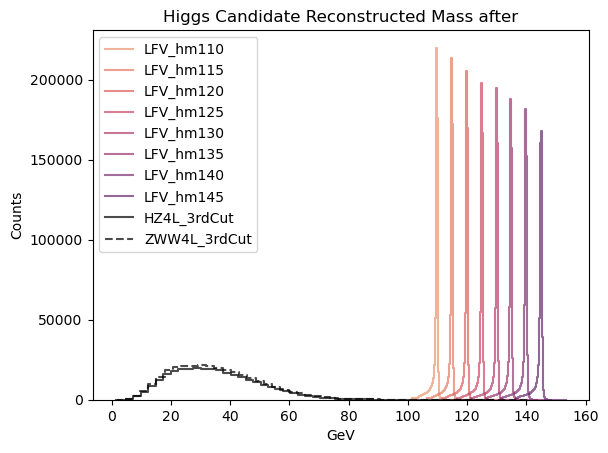

In [ ]:
# Plottthing Higgs reconstructed mass after 4th cut for all LFV signals (layered)
fig=plt.figure()
ax=fig.add_subplot(111)
signalType=["LFV_hm110","LFV_hm115","LFV_hm120","LFV_hm125","LFV_hm130","LFV_hm135","LFV_hm140","LFV_hm145"]
colors=sns.color_palette("flare", len(signalType))
for i,signal in enumerate(signalType):
    a=raw_data[signal]
    cutLevel="5thCut"
    a=a[a[cutLevel]]["Higgs_reconstructedMass"]
    n_arr=(a[~ak.is_none(a)])
    sns.histplot(n_arr, bins=50,  ax=ax, fill=False,
                 element="step", alpha=0.7, color=colors[i],
                 stat="count", multiple="layer", label=signal)
bg1=raw_data['HZ4Lep']['Higgs_reconstructedMass'][raw_data['HZ4Lep']["3rdCut"]]
bg2=raw_data['ZWW4Lep']['Higgs_reconstructedMass'][raw_data['ZWW4Lep']["3rdCut"]]
sns.histplot(bg1[~ak.is_none(bg1)], bins=50,  ax=ax, fill=False,
             element="step", alpha=0.7, color='black',
             stat="count", multiple="layer", label="HZ4L_3rdCut")
sns.histplot(bg2[~ak.is_none(bg2)], bins=50,  ax=ax, fill=False,
             element="step", alpha=0.7, color='black', linestyle='dashed',
             stat="count", multiple="layer", label="ZWW4L_3rdCut")
ax.set_title(f"Higgs Candidate Reconstructed Mass after")
ax.set_xlabel("GeV")
ax.set_ylabel("Counts")
ax.legend(labels=signalType+["HZ4L_3rdCut","ZWW4L_3rdCut"])
plt.show()

In [ ]:
upper_limit = np.array([4.627619057441712,
 4.592590632012857,
 4.637053599249206,
 4.713417939812745,
 4.767666784030083,
 4.759398948068958,
 4.898946768509928,
 4.970215716558242])

In [ ]:
[i for i in range(110,150,5)]

[110, 115, 120, 125, 130, 135, 140, 145]

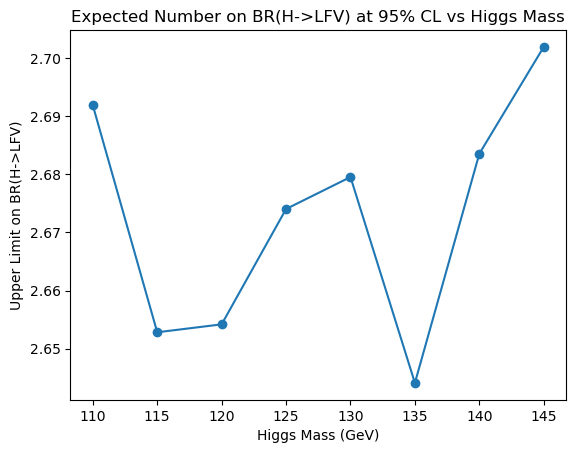

In [ ]:
number=signal_yield*upper_limit
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot([i for i in range(110,150,5)], number, marker='o')
ax.set_title("Expected Number on BR(H->LFV) at 95% CL vs Higgs Mass")
ax.set_xlabel("Higgs Mass (GeV)")
ax.set_ylabel("Upper Limit on BR(H->LFV)")
plt.show()

In [ ]:
signal_yield

[0.581699, 0.577631, 0.572387, 0.567325, 0.562024, 0.555555, 0.54778, 0.543625]

In [ ]:
import awkward as ak
import numpy as np
import uproot

def flatten_collection(array, prefix=""):
    out = {}
    
    # 1. Recurse if it's a Record (has fields like .Eta, .Phi)
    if hasattr(array, "fields") and len(array.fields) > 0:
        for field in array.fields:
            name = f"{prefix}_{field}" if prefix else field
            out.update(flatten_collection(array[field], name))
            
    else:
        # 2. It's a leaf node. Check for Option Types (Nullable data).
        # If the type string contains '?', it means it can be None (e.g., ?float64).
        if "?" in str(array.type):
            if "float" in str(array.type):
                # Replace None with NaN for floats
                array = ak.fill_none(array, np.nan)
            elif "int" in str(array.type):
                # Replace None with -99999 for ints
                array = ak.fill_none(array, -99999)
            elif "bool" in str(array.type):
                # Replace None with False for bools
                array = ak.fill_none(array, False)
                
        out[prefix] = array
        
    return out

# --- Main Execution ---

# 1. Flatten the data first
flattened_data = {}
for name, arr in raw_data.items():
    # Merge the dictionaries from each branch into one big dictionary
    flattened_data.update(flatten_collection(arr, prefix=name))

# 2. Write everything at once
# Note: Writing a single dictionary is often faster/safer than a loop of file[key] = val
with uproot.recreate("/work/project/escience/ruttho/FCC-ee_SimpleDelphesAnalysis/Analysis/root_results/output_file.root") as file:
    file["events"] = flattened_data